In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo


np.set_printoptions(threshold=np.inf)

In [2]:
system="BlackP"
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/"+system+"/"

In [3]:
nkx=64
nky=64
nkz=64


name_Exciton_energy = str(nkx)+'x'+str(nky)+'x'+str(nkz)+'.log'

result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_new/'+name_Exciton_energy, 'E(1)', "1"],capture_output=True,text=True)
E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]



##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"

ψ = Reading.Read_Density(fname)


fname_new="./../../OUT/Band_Structure_out/"+system+"_New_Ham"+"_wann_calc.h5"


epsk_new=Reading.ReadBands(fname_new)

In [4]:
p_ex = np.array([.0,.0,.0])

Ψ_k_p   = Photo.SHIFTING_KplusP(nkx,nky,nkz,ψ[0,:],p_ex)
Ec_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,p_ex)
Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,p_ex)
Env_k_p = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,p_ex)

print(27.2*(np.min(Ec_k_p)-np.max(Ev_k_p)))

EnergySpectrum = np.linspace(np.min(Energie_Valence)+ϵ[0]-0.01,np.max(Energie_Valence)+ϵ[0]+0.015,800)

tolerancia = 0.0005

0.506211188833455


In [49]:
np.max(ψ[0,:])

0.2927020982326788

In [5]:
#===========================================================================
k_points_path = np.array([[0.0,0.0,0.0],[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.5]])
n_kpts=80
new_path = kgrid.K_PATH(k_points_path,n_kpts)
#klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$","X"]

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)



Intensity = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
            Intensity[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])


np.shape(new_path)

(400, 3)

In [5]:
#===========================================================================
delta = 0.1
k_points_path = np.array([[-delta,0.0,0.0],[delta,0.0,0.0]])
n_kpts=140
x_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)
#klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$","X"]

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)


#Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2),dtype=np.complex_)
Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2))

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * abs(Ψ_kpts[kk])

        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk])<= tolerancia:
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


4.551356573866898

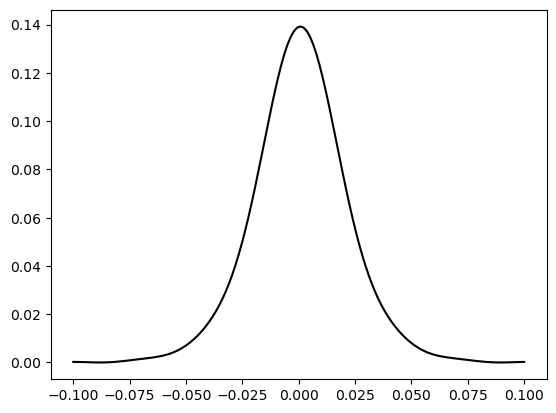

In [6]:
plt.plot(x_kpts, abs(Ψ_kpts), c='black')
sum(Ψ_kpts)

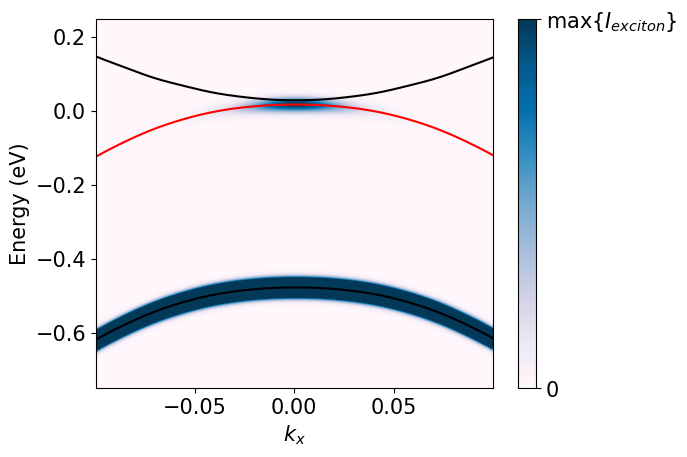

In [7]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
Intensity = IntensityE_plot + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * (Ev_kpts.reshape(n_kpts,1,1)[:,0,0] + ϵ[0]), c='red')
ax1.plot(x_kpts, cst.Ry * Env_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_x$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_X.png",bbox_inches='tight')

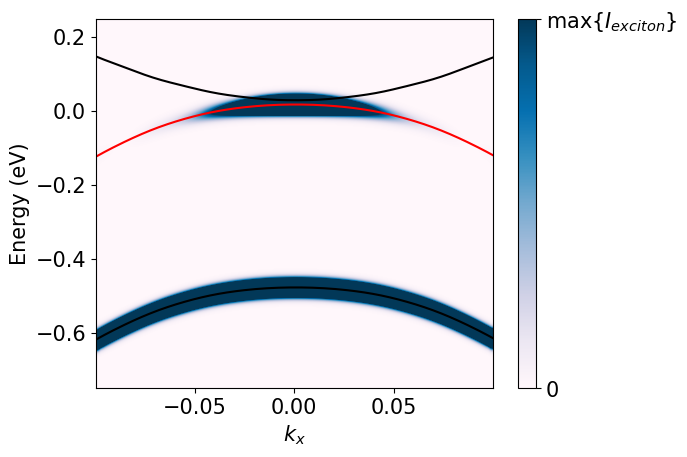

In [8]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')
ax1.plot(x_kpts, cst.Ry * (Ev_kpts.reshape(n_kpts,1,1)[:,0,0] + ϵ[0]), c='red')
ax1.plot(x_kpts, cst.Ry * Env_kpts.reshape(n_kpts,1,1)[:,0,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_x$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

In [9]:
#===========================================================================
delta = 0.1
k_points_path = np.array([[0.0,-delta,0.0],[0.0,delta,0.0]])
n_kpts=140
y_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)
#print(new_path)
#klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$","X"]

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,(Ψ_k_p**4)**(1./4),new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)

#print(Ψ_kpts)

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * abs(Ψ_kpts[kk])

        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk])<= tolerancia:
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


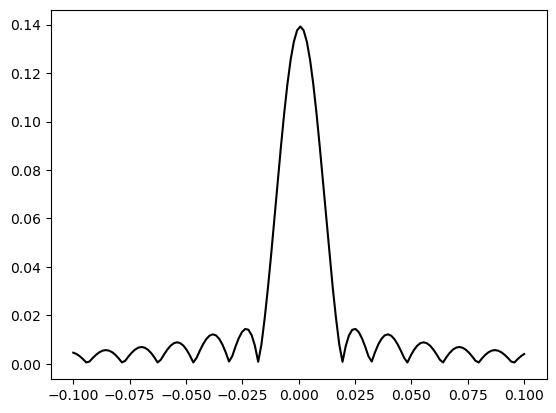

In [10]:
plt.plot(y_kpts, abs(Ψ_kpts), c='black')

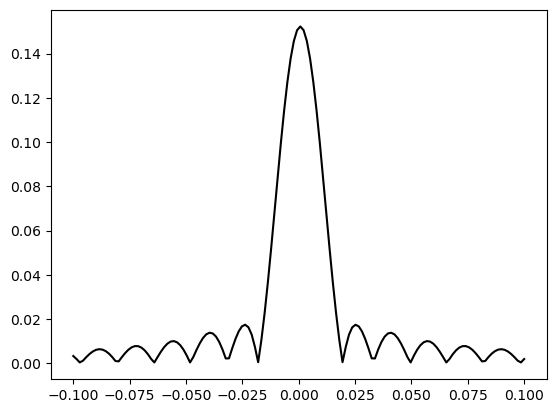

In [35]:
plt.plot(y_kpts, abs(Ψ_kpts), c='black')

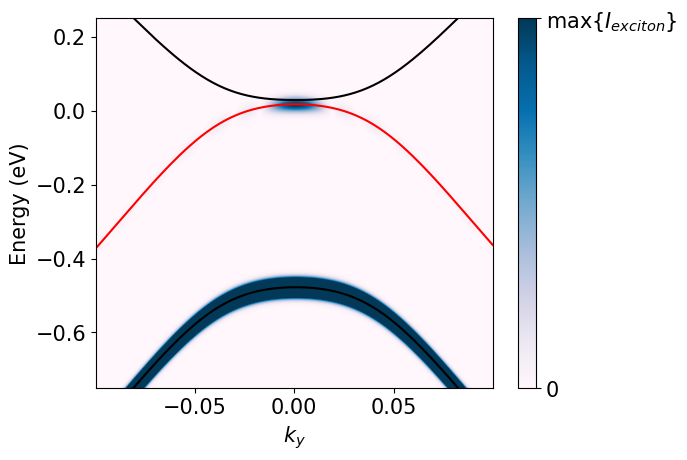

In [11]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
Intensity = IntensityE_plot + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0,np.max(np.abs(IntensityE_plot)),1)
#cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#
#plt.figure(figsize=(5,5))

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[y_kpts.min(),y_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')
#a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity),cbarticks, vmin = 0, vmax = np.max(np.abs(IntensityE_plot)),cmap="Spectral")
#a = ax1.imshow(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity), vmin = 0.0, vmax = np.max(np.abs(IntensityE_plot)))
#b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

#e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

#fig.colorbar(a, ax=ax1, shrink=0.6)
#cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
#cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
#cbar.ax.tick_params(labelsize=15)

ax1.plot(y_kpts, cst.Ry * Ec_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * Ev_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * (Ev_kpts.reshape(1,n_kpts,1)[0,:,0] + ϵ[0]), c='red')
ax1.plot(y_kpts, cst.Ry * Env_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_Y.png",bbox_inches='tight')

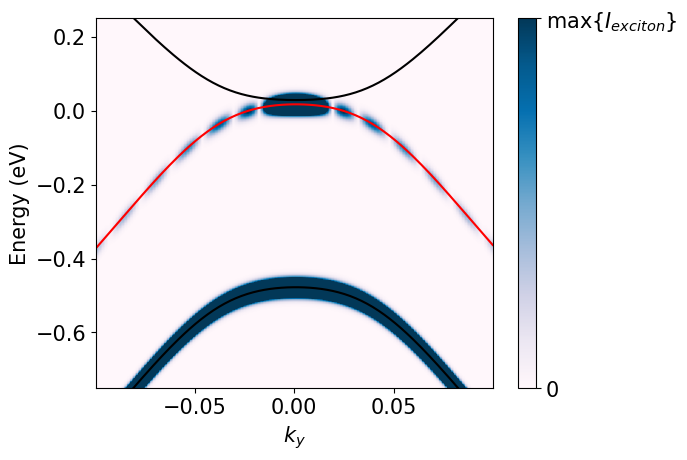

In [12]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),1,n_kpts,1)[:,0,:,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)
#cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#
#plt.figure(figsize=(5,5))

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[y_kpts.min(),y_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',cmap = 'PuBu')
#a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity),cbarticks, vmin = 0, vmax = np.max(np.abs(IntensityE_plot)),cmap="Spectral")
#a = ax1.imshow(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity), vmin = 0.0, vmax = np.max(np.abs(IntensityE_plot)))
#b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

#e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

#fig.colorbar(a, ax=ax1, shrink=0.6)
#cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
#cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
#cbar.ax.tick_params(labelsize=15)

ax1.plot(y_kpts, cst.Ry * Ec_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * Ev_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')
ax1.plot(y_kpts, cst.Ry * (Ev_kpts.reshape(1,n_kpts,1)[0,:,0] + ϵ[0]), c='red')
ax1.plot(y_kpts, cst.Ry * Env_kpts.reshape(1,n_kpts,1)[0,:,0], c='black')

ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


plt.savefig("Spectrum_Y.png",bbox_inches='tight')

In [53]:
nk1=48
nk2=48
nk3=16
delta = 0.1
x_kpts = np.linspace(0-delta,0+delta,nk1)
y_kpts = np.linspace(0-delta,0+delta,nk2)


k_grid = kgrid.GenKgrid(nk1,nk2,nk3,delta,path)

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,k_grid)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,k_grid)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,k_grid)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,k_grid)

print(27.2*(np.min(Ec_kpts)-np.max(Ev_kpts)))

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_C  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_V  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_nV = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
            Intensity_E[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])

        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk])<= tolerancia:
            Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])
            
        if abs(EnergySpectrum[ω_ii]-Env_kpts[kk])<= tolerancia:
            Intensity_nV[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Env_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])
        
        if abs(EnergySpectrum[ω_ii]-Ec_kpts[kk])<= tolerancia:
            Intensity_C[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])

            
####================================================================================



0.5109717455397612


In [54]:
sum(Ψ_kpts)

-0.5049960603246815

In [34]:
nk1=80
nk2=80
nk3=8
delta = 0.1
x_kpts = np.linspace(0-delta,0+delta,nk1)
y_kpts = np.linspace(0-delta,0+delta,nk2)


k_grid = kgrid.GenKgrid(nk1,nk2,nk3,delta,path)

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,k_grid)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,k_grid)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,k_grid)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,k_grid)

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])

        #if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk])<= tolerancia:
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])
            
            

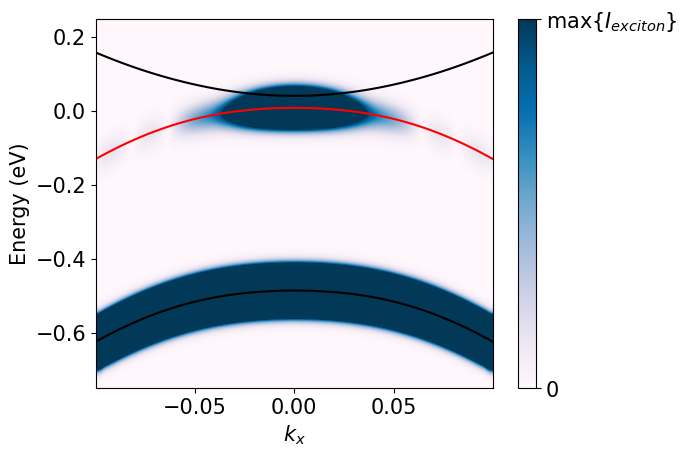

In [35]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0,np.max(np.abs(IntensityE_plot)),1)
#cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#
#plt.figure(figsize=(5,5))

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')
#a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity),cbarticks, vmin = 0, vmax = np.max(np.abs(IntensityE_plot)),cmap="Spectral")
#a = ax1.imshow(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity), vmin = 0.0, vmax = np.max(np.abs(IntensityE_plot)))
#b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

#e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

#fig.colorbar(a, ax=ax1, shrink=0.6)
#cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
#cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
#cbar.ax.tick_params(labelsize=15)

ax1.plot(y_kpts, cst.Ry * Ec_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)], c='black')
ax1.plot(y_kpts, cst.Ry * Ev_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)], c='black')
ax1.plot(y_kpts, cst.Ry * (Ev_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)] + ϵ[0]), c='red')


ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_x$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_Y.png",bbox_inches='tight')

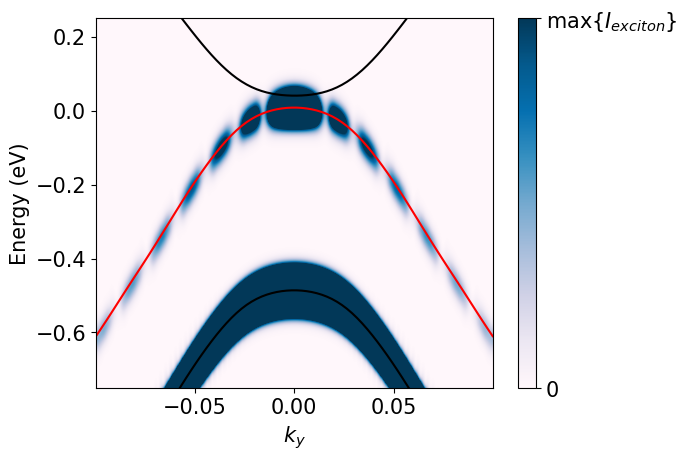

In [36]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0,np.max(np.abs(IntensityE_plot)),1)
#cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#
#plt.figure(figsize=(5,5))

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[y_kpts.min(),y_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')
#a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity),cbarticks, vmin = 0, vmax = np.max(np.abs(IntensityE_plot)),cmap="Spectral")
#a = ax1.imshow(x_kpts,cst.Ry * EnergySpectrum,np.abs(Intensity), vmin = 0.0, vmax = np.max(np.abs(IntensityE_plot)))
#b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

#e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)
cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)  # vertically oriented colorbar

#fig.colorbar(a, ax=ax1, shrink=0.6)
#cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
#cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
#cbar.ax.tick_params(labelsize=15)

ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * (Ev_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)] + ϵ[0]), c='red')


ax1.set_ylim(-2.5,0.5)
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-delta,delta)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_Y.png",bbox_inches='tight')